In [1]:
import pandas as pd
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from data_process import DataProcess
from data_process import GetUsefulLevel
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

F:\SoftwareInstall\Anaconda\envs\pytorch\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [121]:
def print_precison_recall_f1(y_true, y_pre):
    """打印精准率、召回率和F1值"""
    score=dict()
    print(classification_report(y_true, y_pre))
    f1_mac = round(f1_score(y_true, y_pre, average='macro'), 5)
    p_mac = round(precision_score(y_true, y_pre, average='macro'), 5)
    r_mac = round(recall_score(y_true, y_pre, average='macro'), 5)
    
    print("Precision_mac: {}, Recall_mac: {}, F1_mac: {} ".format(p_mac, r_mac, f1_mac))

    f1_mic = round(f1_score(y_true, y_pre, average='micro'), 5)
    p_mic = round(precision_score(y_true, y_pre, average='micro'), 5)
    r_mic = round(recall_score(y_true, y_pre, average='micro'), 5)
    print("Precision_mic: {}, Recall_mic: {}, F1_mic: {} ".format(p_mic, r_mic, f1_mic))
    score={'macro':{'f1_mac':f1_mac,'p_mac':p_mac,'r_mac':r_mac},'micro':{'f1_mic':f1_mic,'p_mic':p_mic,'r_mic':r_mic}}
    return score

def get_data(path):
    df = pd.read_csv(path)
    df.dropna(axis=0, how='any', inplace=True)
    data_process = DataProcess()
    df['reviewComment'] = df['reviewComment'].map(data_process.text_replace)  # 替换评论数据中的乱码字符
    df['reviewComment'] = df['reviewComment'].map(data_process.sen_analy)  # 获取评论数据情感倾向
    df['date'] = df['date'].map(data_process.time_format)  # 获取年份数据
    df.drop(labels=None, axis=1, index=None, columns='recordId', inplace=True)

    useful_level = GetUsefulLevel(df['usefulCount'])
    df['usefulCount'] = df['usefulCount'].map(useful_level.get_current_level)  # 获取count的分级，分为10级
    df['drugName'] = data_process.target_encoder(df['drugName'], df['rating'])  # 对drugName进行目标编码
    df['condition'] = data_process.target_encoder(df['condition'], df['rating'])  # 对condition进行目标编码
    df['sideEffects'] = data_process.side_effect_level(df['sideEffects'])  # 对sideEffects划分等级
    return df

def xgb_train(x_train,y_train):    
    xgboost_clf = XGBClassifier(learning_rate=0.1,min_child_weight=6, max_depth=15,
                               objective='multi:softmax', num_class=5)
    
    xgboost_clf.fit(x_train, y_train)
#     best_model=gsearch.best_estimator_
    # feature_importances_ = xgboost_clf.feature_importances_
    return xgboost_clf

In [3]:
path=r'D:\Python\drug_review_predict\dataset'
train_path=os.path.join(path,'training.csv')
val_path = os.path.join(path, 'validation.csv')
# train_data=get_data(train_path)    

In [38]:
df=pd.read_csv(train_path)

In [39]:
df

,recordId,drugName,condition,reviewComment,date,usefulCount,sideEffects,rating
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...","February 28, 2012",22,Mild Side Effects,5
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...","May 17, 2009",17,Severe Side Effects,4
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""","September 29, 2017",3,No Side Effects,5
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...","March 5, 2017",35,Mild Side Effects,5
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...","October 22, 2015",4,Severe Side Effects,5
...,...,...,...,...,...,...,...,...
6994,21322,Rivastigmine,Alzheimer's Disease,"""I have 7 Immediate Family members that had Al...","February 2, 2016",11,Mild Side Effects,5
6995,172273,Clonazepam,Periodic Limb Movement Disorde,"""Started on 0.5 mg at bedtime for possible res...","May 20, 2017",0,No Side Effects,4
6996,29177,Topiramate,Obesity,"""I am on day 4 now and I am pretty spacey. I ...","December 18, 2016",79,Mild Side Effects,5
6997,197612,Suprep Bowel Prep Kit,Bowel Preparation,"""I could only complete the first session. With...","December 9, 2017",1,No Side Effects,1


In [40]:
def text_replace(text,word='&#039;'):
    return text.replace(word, "'")

In [42]:
df['reviewComment']=df['reviewComment'].map(text_replace)

,recordId,drugName,condition,reviewComment,date,usefulCount,sideEffects,rating
0,163740,Mirtazapine,Depression,"""I've tried a few antidepressants over the yea...","February 28, 2012",22,Mild Side Effects,5
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn's disease and has done very ...","May 17, 2009",17,Severe Side Effects,4
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""","September 29, 2017",3,No Side Effects,5
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...","March 5, 2017",35,Mild Side Effects,5
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...","October 22, 2015",4,Severe Side Effects,5
...,...,...,...,...,...,...,...,...
6994,21322,Rivastigmine,Alzheimer's Disease,"""I have 7 Immediate Family members that had Al...","February 2, 2016",11,Mild Side Effects,5
6995,172273,Clonazepam,Periodic Limb Movement Disorde,"""Started on 0.5 mg at bedtime for possible res...","May 20, 2017",0,No Side Effects,4
6996,29177,Topiramate,Obesity,"""I am on day 4 now and I am pretty spacey. I ...","December 18, 2016",79,Mild Side Effects,5
6997,197612,Suprep Bowel Prep Kit,Bowel Preparation,"""I could only complete the first session. With...","December 9, 2017",1,No Side Effects,1


In [50]:
len(df['sideEffects'].unique())

5

In [49]:
df['usefulCount'].describe()

count    6999.000000
mean       28.189027
std        40.007725
min         0.000000
25%         6.000000
50%        16.000000
75%        35.000000
max       949.000000
Name: usefulCount, dtype: float64

In [ ]:
counts=df['rating'].value_counts()

In [23]:
counts

5    3425
1    1276
4    1196
3     592
2     510
Name: rating, dtype: int64

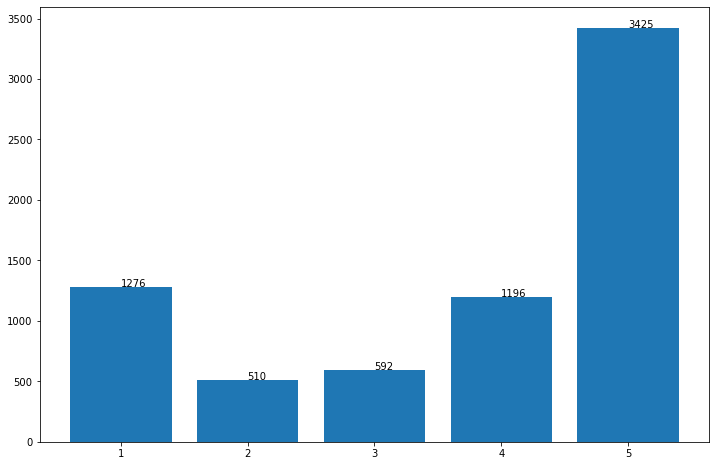

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.bar(counts.index,counts.values)
for x, y in zip(counts.index, counts.values):
    plt.text(x, y + 3, "%s" % y)


In [103]:
train_data 

,drugName,condition,reviewComment,date,usefulCount,sideEffects,rating
0,3.964286,3.789227,0.000000,2012,13,1,5
1,4.249512,3.444535,0.566667,2009,11,3,4
2,3.562500,2.839286,0.333333,2017,4,0,5
3,4.000000,4.329670,0.139063,2017,16,1,5
4,2.791563,3.287747,0.260926,2015,4,3,5
...,...,...,...,...,...,...,...
6994,3.714429,3.501435,0.143056,2016,9,1,5
6995,4.266667,3.085162,0.133929,2017,1,0,4
6996,3.111111,4.100000,0.089464,2016,19,1,5
6997,4.024390,3.814815,0.076042,2017,2,0,1


In [5]:
train_data['reviewComment'].value_counts()

 0.000000    314
 0.250000     59
 0.500000     51
 0.200000     50
 0.100000     38
            ... 
 0.074286      1
-0.091443      1
 0.158586      1
-0.082407      1
 0.076042      1
Name: reviewComment, Length: 4753, dtype: int64

In [210]:
def comment2num(comment):
    if -1<= comment<-0.04:
        return -1
    elif -0.04<=comment<0.04:
        return 0
    else:
        return 1

In [211]:
train_data['reviewComment']=train_data['reviewComment'].map(comment2num)
train_data['reviewComment'].value_counts()

 1    3781
-1    1781
 0    1403
Name: reviewComment, dtype: int64

In [70]:
train_data

,drugName,condition,reviewComment,date,usefulCount,sideEffects,rating
0,3.964286,3.789227,0,2012,13,1,5
1,4.249512,3.444535,1,2009,11,3,4
2,3.562500,2.839286,1,2017,4,0,5
3,4.000000,4.329670,1,2017,16,1,5
4,2.791563,3.287747,1,2015,4,3,5
...,...,...,...,...,...,...,...
6994,3.714429,3.501435,1,2016,9,1,5
6995,4.266667,3.085162,1,2017,1,0,4
6996,3.111111,4.100000,0,2016,19,1,5
6997,4.024390,3.814815,0,2017,2,0,1


In [212]:
x_new_data=pd.DataFrame(columns=train_data.columns[:-1])
y_new_data = pd.DataFrame(columns=[train_data.columns[-1]])
smo = SMOTE(random_state=0)

In [88]:
x_new_data

,drugName,condition,reviewComment,date,usefulCount,sideEffects


In [89]:
y_new_data

,rating


In [213]:
for label in range(1,5):
    x_train=train_data[train_data['rating'].isin([label,5])].iloc[:,:-1]
    y_train=pd.DataFrame(train_data[train_data['rating'].isin([label,5])].iloc[:,-1],columns=['rating'])
    x_train_smo,y_train_smo=smo.fit_resample(x_train,y_train)
    x_new_data=x_new_data.append(x_train_smo[y_train_smo['rating']==label],ignore_index=True)
    y_new_data = y_new_data.append(y_train_smo[y_train_smo['rating']==label], ignore_index=True)

x_new_data=x_new_data.append(train_data[train_data['rating'] == 5].iloc[:, :-1], ignore_index=True)  # 将标签为5的数据合并
y_new_data=y_new_data.append(pd.DataFrame(train_data[train_data['rating'] == 5].iloc[:, -1], columns=['rating']),
                      ignore_index=True)  # 将标签为5的数据合并

C:\Users\mowan\AppData\Local\Temp/ipykernel_8700/252110807.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_new_data=x_new_data.append(x_train_smo[y_train_smo['rating']==label],ignore_index=True)
C:\Users\mowan\AppData\Local\Temp/ipykernel_8700/252110807.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_new_data = y_new_data.append(y_train_smo[y_train_smo['rating']==label], ignore_index=True)
C:\Users\mowan\AppData\Local\Temp/ipykernel_8700/252110807.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_new_data=x_new_data.append(x_train_smo[y_train_smo['rating']==label],ignore_index=True)
C:\Users\mowan\AppData\Local\Temp/ipykernel_8700/252110807.py:6: FutureWarning: The frame.append method is deprecated and will 

In [214]:
xgb_model = xgb_train(x_new_data.values, y_new_data.values)

F:\SoftwareInstall\Anaconda\envs\pytorch\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
F:\SoftwareInstall\Anaconda\envs\pytorch\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\SoftwareInstall\Anaconda\envs\pytorch\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rav

[23:36:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [215]:
train_pred = xgb_model.predict(x_new_data.values)
train_pred

array([1, 1, 5, ..., 5, 5, 5], dtype=object)

In [216]:
pred=train_pred.tolist()
y=y_new_data['rating'].values.tolist()

In [217]:
print('Training score:')
train_score = print_precison_recall_f1(y, pred)

Training score:
              precision    recall  f1-score   support

           1       0.91      0.91      0.91      3412
           2       0.92      0.94      0.93      3412
           3       0.92      0.93      0.93      3412
           4       0.94      0.89      0.91      3412
           5       0.89      0.91      0.90      3412

    accuracy                           0.91     17060
   macro avg       0.91      0.91      0.91     17060
weighted avg       0.91      0.91      0.91     17060

Precision_mac: 0.91463, Recall_mac: 0.91436, F1_mac: 0.91432 
Precision_mic: 0.91436, Recall_mic: 0.91436, F1_mic: 0.91436 


In [218]:
val_data=get_data(val_path)
x_val=val_data.iloc[:,:-1]
y_val=val_data.iloc[:,-1]

dataprocess:


F:\SoftwareInstall\Anaconda\envs\pytorch\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
F:\SoftwareInstall\Anaconda\envs\pytorch\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


In [219]:
x_val['reviewComment']=x_val['reviewComment'].map(comment2num)

In [117]:
x_val

,drugName,condition,reviewComment,date,usefulCount,sideEffects
0,3.333340,3.302752,0,2012,4,1
1,3.706868,2.824577,0,2016,4,3
2,4.191130,3.875000,1,2011,20,1
3,4.976741,3.666667,1,2010,16,2
4,4.538456,3.888889,0,2014,18,0
...,...,...,...,...,...,...
1194,3.706868,3.706868,0,2011,19,0
1195,3.084261,3.400000,1,2011,10,1
1196,4.387533,4.666651,0,2014,10,4
1197,3.706868,4.249505,1,2013,19,1


In [220]:
val_pred = xgb_model.predict(x_val)
val_pred=val_pred.tolist()
y_val=y_val.tolist()

In [119]:
print('Validation score:')
val_score = print_precison_recall_f1(y_val, val_pred)

Validation score:
              precision    recall  f1-score   support

           1       0.47      0.54      0.50       225
           2       0.12      0.21      0.15        82
           3       0.14      0.19      0.16       103
           4       0.22      0.29      0.25       192
           5       0.75      0.51      0.60       592

    accuracy                           0.43      1194
   macro avg       0.34      0.35      0.33      1194
weighted avg       0.52      0.43      0.46      1194

Precision_mac: 0.3402, Recall_mac: 0.3472, F1_mac: 0.33429 
Precision_mic: 0.42965, Recall_mic: 0.42965, F1_mic: 0.42965 


In [134]:
print('Validation score:')
val_score = print_precison_recall_f1(y_val, val_pred)

Validation score:
              precision    recall  f1-score   support

           1       0.47      0.54      0.50       225
           2       0.12      0.21      0.15        82
           3       0.14      0.19      0.16       103
           4       0.22      0.29      0.25       192
           5       0.75      0.51      0.60       592

    accuracy                           0.43      1194
   macro avg       0.34      0.35      0.33      1194
weighted avg       0.52      0.43      0.46      1194

Precision_mac: 0.3402, Recall_mac: 0.3472, F1_mac: 0.33429 
Precision_mic: 0.42965, Recall_mic: 0.42965, F1_mic: 0.42965 


In [144]:
print('Validation score:')
val_score = print_precison_recall_f1(y_val, val_pred)

Validation score:
              precision    recall  f1-score   support

           1       0.44      0.51      0.47       225
           2       0.13      0.26      0.17        82
           3       0.12      0.17      0.14       103
           4       0.21      0.30      0.25       192
           5       0.79      0.47      0.59       592

    accuracy                           0.41      1194
   macro avg       0.34      0.34      0.33      1194
weighted avg       0.53      0.41      0.45      1194

Precision_mac: 0.33853, Recall_mac: 0.34181, F1_mac: 0.32541 
Precision_mic: 0.41122, Recall_mic: 0.41122, F1_mic: 0.41122 


In [157]:
print('Validation score:')
val_score = print_precison_recall_f1(y_val, val_pred)

Validation score:
              precision    recall  f1-score   support

           1       0.45      0.64      0.53       225
           2       0.09      0.12      0.11        82
           3       0.17      0.14      0.15       103
           4       0.25      0.20      0.22       192
           5       0.70      0.63      0.66       592

    accuracy                           0.48      1194
   macro avg       0.33      0.35      0.33      1194
weighted avg       0.49      0.48      0.48      1194

Precision_mac: 0.33262, Recall_mac: 0.34538, F1_mac: 0.33398 
Precision_mic: 0.48409, Recall_mic: 0.48409, F1_mic: 0.48409 


In [171]:
print('Validation score:')
val_score = print_precison_recall_f1(y_val, val_pred)

Validation score:
              precision    recall  f1-score   support

           1       0.45      0.66      0.54       225
           2       0.09      0.10      0.09        82
           3       0.20      0.14      0.16       103
           4       0.26      0.22      0.24       192
           5       0.69      0.63      0.66       592

    accuracy                           0.49      1194
   macro avg       0.34      0.35      0.34      1194
weighted avg       0.49      0.49      0.49      1194

Precision_mac: 0.33862, Recall_mac: 0.34958, F1_mac: 0.33829 
Precision_mic: 0.49246, Recall_mic: 0.49246, F1_mic: 0.49246 


In [184]:
print('Validation score:')
val_score = print_precison_recall_f1(y_val, val_pred)

Validation score:
              precision    recall  f1-score   support

           1       0.44      0.68      0.54       225
           2       0.08      0.09      0.08        82
           3       0.19      0.09      0.12       103
           4       0.27      0.22      0.24       192
           5       0.68      0.65      0.66       592

    accuracy                           0.50      1194
   macro avg       0.33      0.34      0.33      1194
weighted avg       0.49      0.50      0.48      1194

Precision_mac: 0.33298, Recall_mac: 0.34335, F1_mac: 0.32883 
Precision_mic: 0.49665, Recall_mic: 0.49665, F1_mic: 0.49665 


In [198]:
print('Validation score:')
val_score = print_precison_recall_f1(y_val, val_pred)

Validation score:
              precision    recall  f1-score   support

           1       0.44      0.67      0.53       225
           2       0.09      0.10      0.09        82
           3       0.20      0.11      0.14       103
           4       0.27      0.22      0.24       192
           5       0.69      0.64      0.66       592

    accuracy                           0.50      1194
   macro avg       0.34      0.35      0.33      1194
weighted avg       0.49      0.50      0.49      1194

Precision_mac: 0.33879, Recall_mac: 0.34756, F1_mac: 0.33481 
Precision_mic: 0.49665, Recall_mic: 0.49665, F1_mic: 0.49665 


In [221]:
print('Validation score:')
val_score = print_precison_recall_f1(y_val, val_pred)

Validation score:
              precision    recall  f1-score   support

           1       0.44      0.50      0.47       225
           2       0.09      0.21      0.13        82
           3       0.08      0.11      0.09       103
           4       0.23      0.29      0.25       192
           5       0.75      0.48      0.59       592

    accuracy                           0.40      1194
   macro avg       0.32      0.32      0.31      1194
weighted avg       0.51      0.40      0.44      1194

Precision_mac: 0.31866, Recall_mac: 0.31663, F1_mac: 0.30631 
Precision_mic: 0.40369, Recall_mic: 0.40369, F1_mic: 0.40369 
